In [17]:
import pandas as pd
import numpy as np
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# for training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# for optimize
from skopt import gp_minimize, Optimizer
from skopt.space import Space, Integer, Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# custom packages
from bayes_opt import custom_minimize, resume_optimize
from agent import AgentBase

import matplotlib.pyplot as plt


In [18]:
# meta config
random_seed = 2022

In [19]:
data = pd.read_csv("./data/boston_housing.csv")
data.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [20]:
X = data.drop(columns=['medv'])
y = data['medv'].values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.33, random_state=random_seed)

In [22]:
def train_and_evaluate(params):
    n_components, alpha = params[0], params[1]
    # PCA Analysis
    pca = PCA(n_components=round(n_components))
    pca.fit(X_train)
    X_train_tranformed = pca.transform(X_train)
    clf = Ridge(alpha=alpha).fit(X_train_tranformed, y_train)
    X_test_transformed = pca.transform(X_test)
    y_pred = clf.predict(X_test_transformed)
    return mean_squared_error(y_test, y_pred)

In [23]:
space = Space((Integer(1, 12), Real(0.001, 10, prior="log-uniform", base=10)))
x0 = [(2, 1.0)]

In [24]:
res = gp_minimize(train_and_evaluate,        # the function to minimize
                    space,      # the bounds on each dimension of x
                    initial_point_generator="grid",
                    x0=x0,
                    acq_func="EI",      # the acquisition function
                    n_calls=20,         # the number of evaluations of f
                    n_random_starts=5,  # the number of random initialization points
                    noise="gaussian",       # the noise level (optional)
                    n_jobs=-1,
                    random_state=random_seed
                )   # the random seed

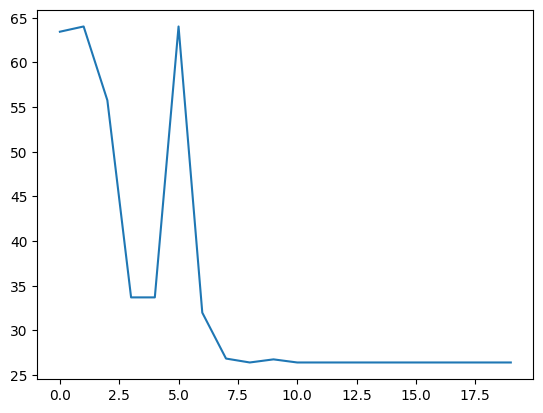

In [25]:
plt.plot(res.func_vals)

In [33]:
agent_a = AgentBase(dim=0, random_seed=random_seed)
agent_b = AgentBase(dim=1, random_seed=random_seed)

In [34]:
res, optimizer = agent_a.initialize_model(
                            train_and_evaluate, 
                            space, 
                            x0,
                            initial_point_generator="grid",
                            acq_func="EI",      # the acquisition function
                            n_random_starts=10,         # the number of evaluations of f
                        )

In [36]:
# params
records = res.func_vals
budget_a = budget_b = 5
res_resume_b = res
res_resume_a = None
n_iter = 100

for _ in range(n_iter):
    if agent_a.has_improvement(next_res=res_resume_b, prev_res=res_resume_a) and \
                not agent_a.need_punish:
        # Agent A iterates
        agent_a.punish_count = 0
        other_dim = agent_b.dim
        other_val = res_resume_b.x[other_dim]

        res_resume_a, optimizer, xs, ys = agent_a.update(
                                            train_and_evaluate,
                                            budget_a,
                                            res_resume_b,
                                            optimizer,
                                            other_dim,
                                            other_val
                                            )
        records = np.concatenate([records, ys])
    else:
        # if no improvement, punish
        agent_a.punish_count += 1

    if agent_b.has_improvement(next_res=res_resume_a, prev_res=res_resume_b) and \
                    not agent_b.need_punish:
        # Agent B iterates
        agent_b.punish_count = 0
        other_dim = agent_a.dim
        other_val = res_resume_a.x[other_dim]

        res_resume_b, optimizer, xs, ys = agent_b.update(
                                            train_and_evaluate,
                                            budget_b,
                                            res_resume_a,
                                            optimizer,
                                            other_dim,
                                            other_val
                                            )
        records = np.concatenate([records, ys])
    else:
        # if no improvement, punish
        agent_b.punish_count += 1

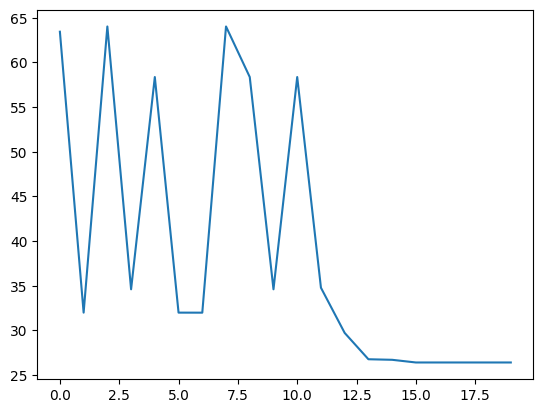

In [37]:
plt.plot(records)